# Evaluation Pipeline application to random baseline

## Imports

In [2]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, precision_score, recall_score, 
    f1_score, log_loss, hamming_loss, classification_report, confusion_matrix
)
from sklearn.utils import resample
from datasets import Dataset, load_from_disk


## Load data

In [66]:
data_path = os.path.join("..","data","train_val")

absolute_path = os.path.abspath(data_path)

print(absolute_path)

# Add the 'baseline' column with the sampled predictions to the test set
dataset = load_from_disk(absolute_path)

C:\Users\49176\Unistuff\PP2\prostT5-CLIP\data\train_val


In [67]:
dataset

DatasetDict({
    train: Dataset({
        features: ['identifier', 'sequence', 'species'],
        num_rows: 113796
    })
    test: Dataset({
        features: ['identifier', 'sequence', 'species'],
        num_rows: 28450
    })
})

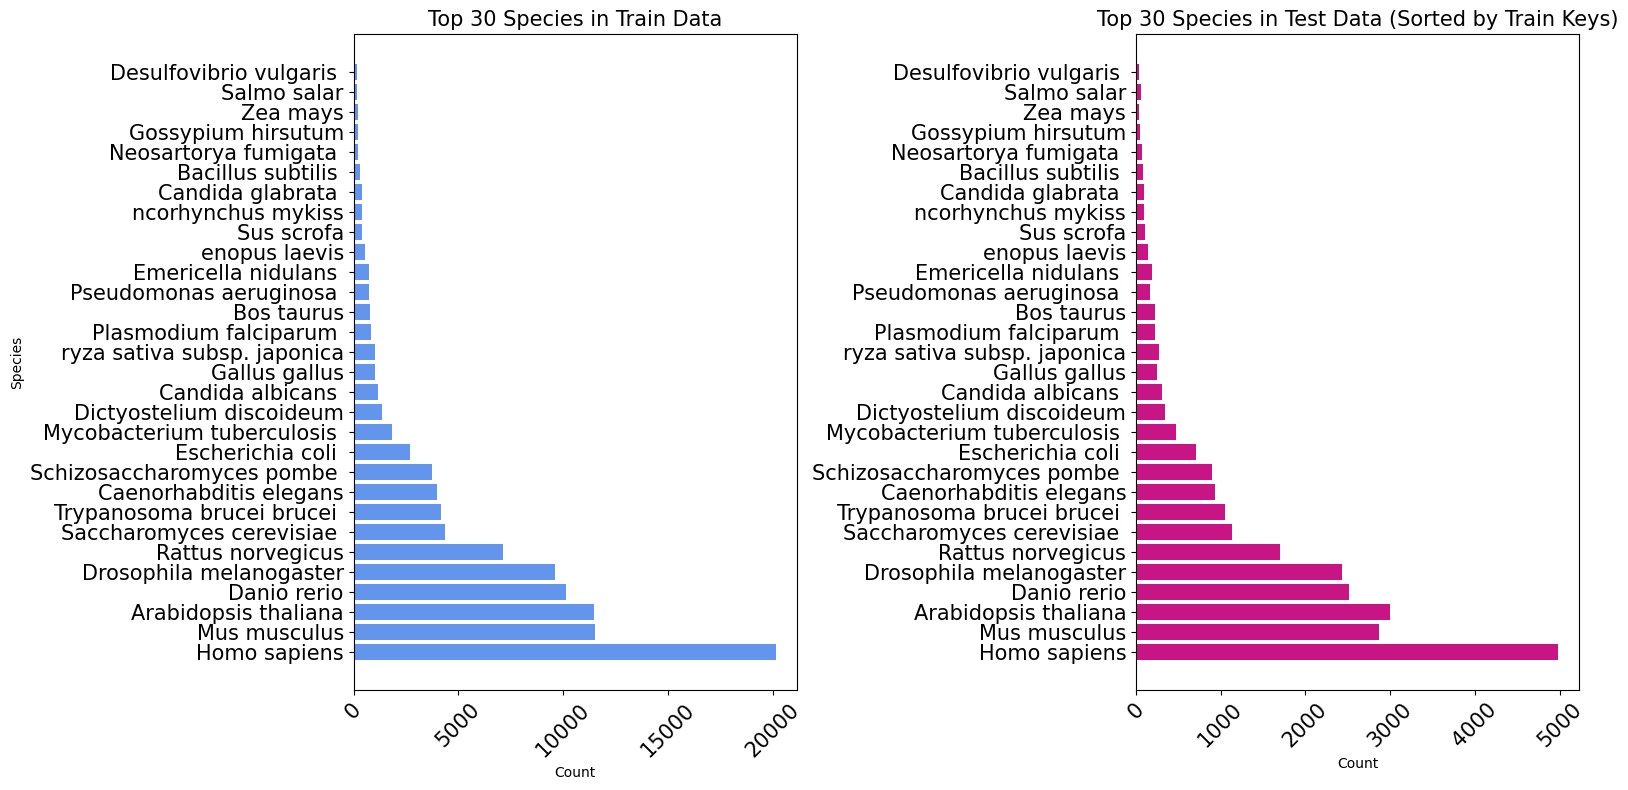

In [68]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

# Load dataset
# Assuming 'dataset' is already loaded before

train_species = dataset['train']['species']
test_species = dataset['test']['species']

# Create DataFrames for train and test species occurrences
train_species_df = pd.DataFrame(train_species, columns=['species']).value_counts().reset_index(name='count')
test_species_df = pd.DataFrame(test_species, columns=['species']).value_counts().reset_index(name='count')

# Rename columns for better readability
train_species_df.columns = ['species', 'count']
test_species_df.columns = ['species', 'count']

# Get the top 30 species from the train dataset
train_top_30_df = train_species_df.head(30)

# Sort the test species occurrences by the keys from train_top_30
test_sorted_by_train_keys_df = test_species_df[test_species_df['species'].isin(train_top_30_df['species'])]
test_sorted_by_train_keys_df = test_sorted_by_train_keys_df.set_index('species').reindex(train_top_30_df['species']).reset_index()

# Create subplots with two separate axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the training species occurrences
ax1.barh(train_top_30_df['species'], train_top_30_df['count'], color="cornflowerblue")
ax1.set_title('Top 30 Species in Train Data', fontsize=15)
ax1.set_xlabel('Count')
ax1.set_ylabel('Species')

# Plot the testing species occurrences sorted by the train species keys
ax2.barh(test_sorted_by_train_keys_df['species'], test_sorted_by_train_keys_df['count'], color="mediumvioletred")
ax2.set_title('Top 30 Species in Test Data (Sorted by Train Keys)', fontsize=15)
ax2.set_xlabel('Count')

# Set tick parameters
ax1.tick_params(axis='x', rotation=45, labelsize=15)
ax2.tick_params(axis='x', rotation=45, labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

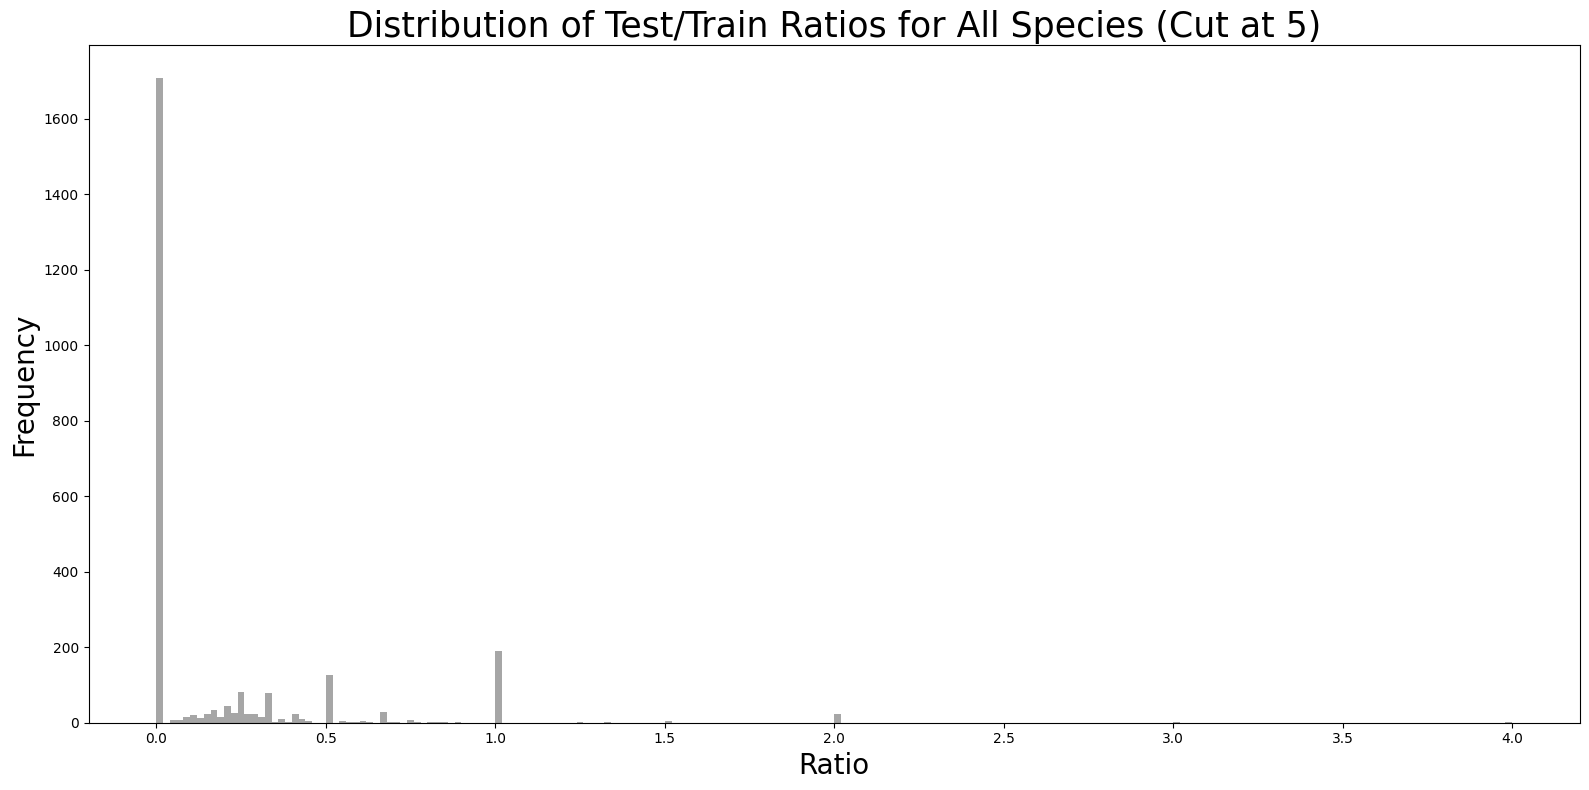

In [78]:
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
import pandas as pd

# Load dataset
# Assuming 'dataset' is already loaded before

train_species = dataset['train']['species']
test_species = dataset['test']['species']

# Count species occurrences in the train and test data
train_species_counts = Counter(train_species)
test_species_counts = Counter(test_species)

# Calculate the ratio of test to train counts for each species
ratios = {species: test_species_counts[species] / train_species_counts[species] if train_species_counts[species] > 0 else 0 for species in train_species_counts.keys()}

# Create a histogram of all species ratios
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(ratios.values(), bins=200, color='gray', alpha=0.7)
ax.set_title('Distribution of Test/Train Ratios for All Species (Cut at 5)', fontsize=25)
ax.set_xlabel('Ratio', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [73]:
from collections import Counter
from datasets import load_dataset
import pandas as pd

# Load dataset
# Assuming 'dataset' is already loaded before

train_species = dataset['train']['species']
test_species = dataset['test']['species']

# Count species occurrences in the train and test data
train_species_counts = Counter(train_species)
test_species_counts = Counter(test_species)

# Calculate the ratio of test to train counts for each species
ratios = {species: test_species_counts[species] / train_species_counts[species] if train_species_counts[species] > 0 else 0 for species in train_species_counts.keys()}

# Sort by ratio and get the top 30 species with the highest ratios
top_30_ratios = dict(sorted(ratios.items(), key=lambda item: item[1], reverse=True))

# Get counts of top 30 species in train and test datasets
train_top_30_counts = [train_species_counts[species] for species in top_30_ratios.keys()]
test_top_30_counts = [test_species_counts[species] for species in top_30_ratios.keys()]

# Create a DataFrame to display the top 30 species, their ratios, and counts in train and test datasets
data = {
    'Species': list(top_30_ratios.keys()),
    'Ratio (Test/Train)': list(top_30_ratios.values()),
    'Train Count': train_top_30_counts,
    'Test Count': test_top_30_counts
}

df_top_30 = pd.DataFrame(data)

# Display the table


In [79]:
df_top_30.sort_values("Train Count",ascending=False).head(30)

,Species,Ratio (Test/Train),Train Count,Test Count
677,Homo sapiens,0.247430,20139,4983
674,Mus musculus,0.249479,11512,2872
600,Arabidopsis thaliana,0.261207,11466,2995
676,Danio rerio,0.248006,10153,2518
615,Drosophila melanogaster,0.253128,9592,2428
684,Rattus norvegicus,0.239736,7112,1705
602,Saccharomyces cerevisiae,0.259881,4352,1131
617,Trypanosoma brucei brucei,0.251863,4161,1048
688,Caenorhabditis elegans,0.234925,3980,935
680,Schizosaccharomyces pombe,0.241028,3734,900


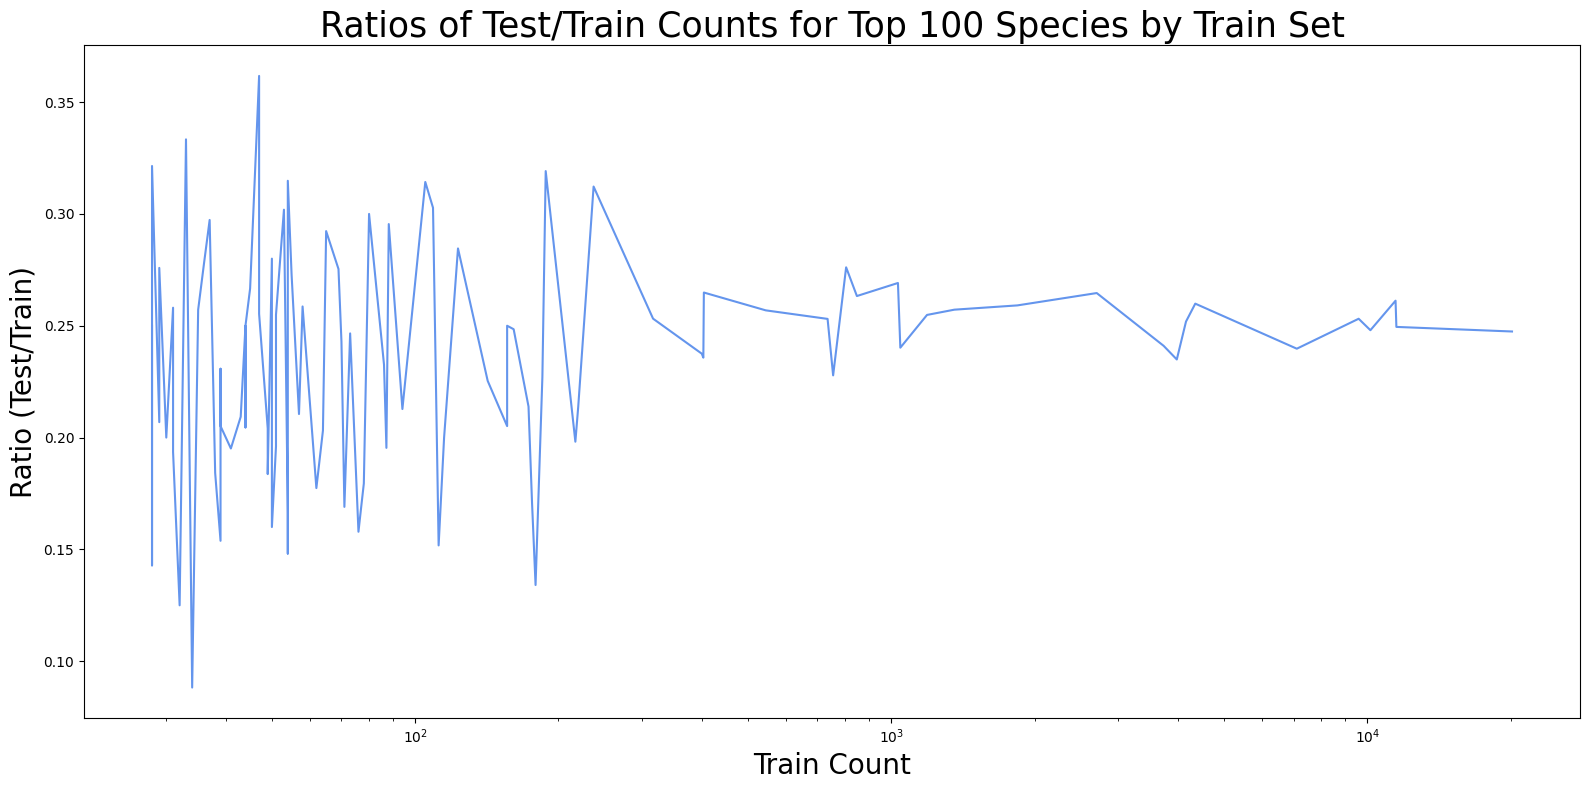

In [80]:
# Create a line plot of ratios sorted by the train set for the top 30 species
fig, ax = plt.subplots(figsize=(16, 8))
sorted_df_top_30 = df_top_30.sort_values("Train Count",ascending=False).head(100)
ax.plot(sorted_df_top_30['Train Count'], sorted_df_top_30['Ratio (Test/Train)'], color='cornflowerblue', marker=None)
ax.set_title('Ratios of Test/Train Counts for Top 100 Species by Train Set', fontsize=25)
ax.set_xlabel('Train Count', fontsize=20)
ax.set_ylabel('Ratio (Test/Train)', fontsize=20)
ax.tick_params(axis='x', rotation=0)
ax.set_xscale('log')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
